# Trabajo Final - Lenguaje de Programación 2
### Título del Proyecto
**Sistema de Monitoreo y Comparación de Precios de Hardware (Smarth Shop)**

### Nota

Todo el desarrollo del proyecto se ha realizado respetando las directivas del archivo robots.txt y los términos de servicio de las páginas web y APIs consultadas. Asimismo, se implementaron tiempos de espera (delays) entre las solicitudes para evitar la sobrecarga de los servidores externos y asegurar una extracción responsable de la información.

### Introducción y Relevancia del Proyecto

En un contexto económico marcado por la inflación y la constante variación de precios, los consumidores peruanos enfrentan dificultades para identificar ofertas reales en productos tecnológicos como laptops y componentes de hardware. Muchas veces, las promociones mostradas en tiendas virtuales no reflejan un verdadero ahorro, lo que genera desinformación y decisiones de compra poco óptimas.

El proyecto **Smart Shop** surge como una solución tecnológica orientada a centralizar, comparar y normalizar precios de productos de hardware provenientes de distintas tiendas, permitiendo a los usuarios identificar el precio más bajo disponible en el mercado al momento de la consulta. De esta manera, el sistema contribuye al ahorro económico, fomenta decisiones de compra informadas y protege el poder adquisitivo de personas que dependen de la tecnología para estudiar, trabajar o emprender.

### Objetivos del Proyecto
#### Objetivo General

Desarrollar un sistema automatizado en Python que permita monitorear y comparar precios de productos tecnológicos entre diferentes retailers, presentando la información de forma estructurada y estandarizada.

#### Objetivos Específicos

- Desarrollar un bot en Python capaz de extraer diariamente precios de laptops y componentes de hardware desde tiendas reconocidas.
- Implementar la normalización de moneda (USD a PEN) en tiempo real mediante el consumo de una API de tipo de cambio.
- Generar un dataset estructurado en formato CSV que permita analizar y visualizar la dispersión de precios de un mismo producto.
- Facilitar la identificación del producto más económico disponible en la fecha de ejecución del sistema.

### Fuentes de Datos y Estrategia de Extracción

El proyecto utiliza **tres tipos de fuentes de datos**, cumpliendo con los requisitos del curso y aplicando distintas técnicas de adquisición de información:

#### Fuente 1: Web Scraping Estático
- **Amazon**
- Se emplea la librería **BeautifulSoup** para extraer información de catálogos de laptops.
- Los datos recolectados incluyen: nombre del producto, precio, descripción y vendedor.
- Esta fuente permite obtener información estructurada directamente desde el HTML estático.

#### Fuente 2: Web Scraping Dinámico
- **Plaza Vea, Coolbox y Falabella**
- Se utiliza **Selenium** para renderizar contenido dinámico generado mediante JavaScript.
- Se extraen precios y ofertas exclusivas disponibles únicamente en la web.
- Esta técnica permite acceder a información que no está disponible mediante scraping tradicional.

#### Fuente 3: API Pública
- **ExchangeRate-API**
- Se consume una API REST para obtener el tipo de cambio actualizado entre dólares estadounidenses (USD) y soles peruanos (PEN).
- Esta información es clave para estandarizar todos los precios recolectados y permitir una comparación precisa entre tiendas.

### Integración y Tratamiento de Datos

Una vez obtenidos los datos desde las distintas fuentes, el sistema realiza un proceso de integración y limpieza que incluye:
- Conversión de todos los precios a moneda local (PEN).
- Normalización de nombres de productos para facilitar la comparación.
- Eliminación de registros duplicados.
- Manejo de valores nulos o inconsistentes.

El resultado de este proceso es un dataset limpio y estructurado, listo para su análisis posterior.

### Producto Final

El producto final del proyecto consiste en:
- Un **repositorio en GitHub** que contiene todo el código fuente, documentado y organizado por módulos.
- Un **archivo CSV/Excel** que presenta la comparación de precios de los productos analizados.
- Un reporte que permite identificar claramente cuál es el producto más barato del mercado en la fecha de ejecución del sistema.

Este sistema puede servir como base para futuras extensiones, como visualizaciones interactivas, alertas de precios o una aplicación web orientada al consumidor final.

### Tecnologías Utilizadas
- **Lenguaje:** Python 3.x
- **Librerías principales:**
    - Requests
    - BeautifulSoup4
    - Selenium
    - Pandas

- **Formato de salida:** CSV / Excel
- **Control de versiones:** Git y GitHub

### Importación de librerías necesarias para la extracción, procesamiento y almacenamiento de datos

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
import time
import os

### Configuración de parámetros para Amazon y definición de función de limpieza de precios
En esta sección se definen los parámetros base para realizar el scraping de productos desde Amazon, incluyendo el término de búsqueda, la cantidad de páginas a recorrer y las cabeceras HTTP necesarias para simular un navegador real. Asimismo, se implementa una función auxiliar para la limpieza y normalización de precios, la cual será utilizada en etapas posteriores del proceso de extracción y análisis de datos.

In [ ]:
# --- 1. CONFIGURACIÓN INICIAL PARA AMAZON ---
TERMINO_BUSQUEDA = "computadores"
URL_INICIAL = f"https://www.amazon.com/s?k={TERMINO_BUSQUEDA}" 
NUMERO_DE_PAGINAS = 5  # Extracción de 5 páginas


# Headers avanzados para simular un navegador genuino y reducir
# la probabilidad de bloqueos durante el scraping
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Referer': 'https://www.amazon.com/', 
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Language': 'es-ES,es;q=0.9',
    'Cookie': 'custom_cookie=true',
    'Connection': 'keep-alive',
}


# --- FUNCIÓN AUXILIAR PARA LIMPIEZA DE PRECIOS ---
# Esta función permite transformar los precios extraídos desde
# la web (en formato texto) a un formato numérico estándar,
# eliminando símbolos monetarios, separadores de miles y texto
# irrelevante, con el fin de permitir cálculos y comparaciones.
def limpiar_precio(precio_str):
    """
    Limpia y normaliza el precio extraído como texto, eliminando
    símbolos monetarios, texto adicional y separadores innecesarios,
    garantizando un formato numérico adecuado para análisis posterior.

    Parámetros:
    precio_str (str): Precio en formato texto obtenido durante el scraping.

    Retorna:
    float | None: Precio convertido a tipo float o None si la conversión falla.
    """
    if isinstance(precio_str, str):
        # 1. Eliminar caracteres no deseados y texto de referencia
        precio_limpio = precio_str.replace('\u00a0', ' ').replace('USD', '').replace('PEN', '').replace('S/', '').replace('$', '').replace('PVPR:', '').replace('Lista:', '').strip()
        
        # 2. Manejar separadores: eliminar comas utilizadas como separadores de miles
        precio_limpio = precio_limpio.replace(',', '') 
        
        # 3. Forzar formato de un solo punto decimal, eliminando puntos adicionales
        if precio_limpio.count('.') > 1:
            partes = precio_limpio.rsplit('.', 1) 
            entero = partes[0].replace('.', '') 
            decimal = partes[1] if len(partes) > 1 else '00'
            precio_limpio = f"{entero}.{decimal}"
        
        # 4. Asegurar que no exista doble punto residual
        precio_limpio = precio_limpio.replace('..', '.')
        
        try:
            # 5. Conversión final a tipo float
            return float(precio_limpio.strip())
        except ValueError:
            return None
    return None

### FUNCIÓN DE SOLICITUD HTTP Y PARSEO DEL CONTENIDO HTML
Esta función centraliza el proceso de conexión a la página web, realizando la solicitud HTTP y transformando la respuesta en un objeto BeautifulSoup. De esta manera, se desacopla la lógica de descarga del contenido de la lógica de extracción de datos, facilitando la reutilización del código y el mantenimiento del sistema.

In [ ]:
# --- 2. FUNCIÓN DE SOLICITUD HTTP Y PARSEO ---
def obtener_contenido_pagina(url):
    """
    Realiza una solicitud HTTP GET a la URL indicada y devuelve el
    contenido HTML parseado como un objeto BeautifulSoup.

    Esta función incorpora manejo de errores y validación del código
    de estado HTTP, asegurando que solo se procese contenido válido
    durante la etapa de scraping.

    Parámetros:
    url (str): Dirección web de la página a consultar.

    Retorna:
    BeautifulSoup | None: Objeto BeautifulSoup con el HTML parseado
    o None si ocurre un error durante la solicitud.
    """
    try:
        response = requests.get(url, headers=HEADERS, timeout=15)
        
        # Mostrar el código de estado HTTP para fines de monitoreo
        print(f"    - Código de estado HTTP recibido: {response.status_code}") 
        
        # Lanza una excepción si la respuesta HTTP indica error
        response.raise_for_status() 

        # Parseo del contenido HTML con BeautifulSoup
        return BeautifulSoup(response.content, "html.parser")

    except requests.exceptions.RequestException as e:
        # Manejo de errores de conexión, timeout o respuesta inválida
        print(f"❌ Error al realizar la solicitud a {url}: {e}")
        return None

### FUNCIÓN DE EXTRACCIÓN, FILTRADO Y PROCESAMIENTO DE OFERTAS
Esta función se encarga de recorrer el contenido HTML previamente parseado de Amazon y extraer información relevante únicamente de productos que presentan una oferta real (precio anterior y precio actual). Se aplica un filtrado estricto para garantizar que los datos obtenidos sean consistentes y útiles para el análisis comparativo de precios.

In [ ]:
# --- 3. FUNCIÓN DE EXTRACCIÓN Y FILTRADO ESTRICTO ---
def extraer_datos_amazon_ofertas(soup):
    """
    Extrae información de productos en oferta desde el HTML de Amazon,
    aplicando un filtrado estricto para conservar únicamente aquellos
    productos que cuentan con nombre, precio anterior y precio actual.

    La función también calcula el porcentaje de descuento utilizando
    valores numéricos normalizados, garantizando consistencia para
    análisis posteriores.

    Parámetros:
    soup (BeautifulSoup): Objeto BeautifulSoup con el HTML parseado
    de la página de resultados de Amazon.

    Retorna:
    list: Lista de diccionarios con la información estructurada de
    cada producto válido encontrado.
    """
    datos_productos = []

    # Selector principal de contenedores de productos
    contenedores_productos = soup.find_all('div', {'data-component-type': 's-search-result'})
    
    # Mensaje informativo sobre la cantidad de productos encontrados
    print(f"    -> Productos encontrados para extraer: {len(contenedores_productos)}")

    for contenedor in contenedores_productos:
        
        # Inicialización de variables con valores por defecto
        nombre = 'N/A'
        precio_antes = 'N/A'
        precio_despues = 'N/A'
        url_image = 'N/A'
        
        # --- Extracción del nombre del producto ---
        titulo_h2 = contenedor.find('h2')
        if titulo_h2:
            span_titulo = titulo_h2.find('span')
            nombre = span_titulo.text.strip() if span_titulo else titulo_h2.text.strip()
        
        # --- Extracción del precio actual (precio_despues) ---
        precio_span = contenedor.find('span', class_='a-price')
        if precio_span:
            p_entero = precio_span.find('span', class_='a-price-whole')
            p_fraccion = precio_span.find('span', class_='a-price-fraction')
            moneda = precio_span.find('span', class_='a-price-symbol')
            
            p_entero_str = p_entero.text.strip() if p_entero else ''
            p_fraccion_str = p_fraccion.text.strip() if p_fraccion else ''
            moneda_str = moneda.text.strip() if moneda else 'USD'
            
            if p_entero_str or p_fraccion_str:
                # Construcción del precio en formato texto limpio
                precio_despues = f"{moneda_str} {p_entero_str}.{p_fraccion_str}".replace('\xa0', ' ').replace('..', '.') 

        # --- Extracción del precio anterior (precio_antes) ---
        precio_antes_tag = contenedor.find('span', class_='a-price', attrs={'data-a-strike': 'true'})
        
        if precio_antes_tag:
            offscreen_price = precio_antes_tag.find('span', class_='a-offscreen')
            if offscreen_price:
                precio_antes = offscreen_price.text.strip().replace('\u00a0', ' ')
            else:
                precio_antes = precio_antes_tag.text.strip().replace('\u00a0', ' ')
            
            # Limpieza adicional del texto del precio anterior
            precio_antes = precio_antes.replace('PVPR:', '').replace('Lista:', '').strip().replace('..', '.')
        
        # --- Extracción de la URL de la imagen del producto ---
        imagen_tag = contenedor.find('img', class_='s-image')
        url_image = imagen_tag.get('src') if imagen_tag and imagen_tag.get('src') else 'N/A'
        
        # --- Cálculo del descuento ---
        descuento = '0%'
        
        # Conversión de precios a formato numérico para el cálculo
        num_despues = limpiar_precio(precio_despues)
        num_antes = limpiar_precio(precio_antes) 
        
        if num_antes and num_despues and num_antes > num_despues:
            calc_descuento = ((num_antes - num_despues) / num_antes) * 100
            descuento = f"{calc_descuento:.0f}%" 
        
        # --- FILTRO ESTRICTO ---
        # Solo se agregan productos con nombre, precio actual y precio anterior válidos
        if nombre != 'N/A' and precio_despues != 'N/A' and precio_antes != 'N/A':
            datos_productos.append({
                "nombre": nombre.replace('\u00a0', ' '),
                "precio_antes": precio_antes.replace('\u00a0', ' '),
                "precio_despues": precio_despues.replace('\u00a0', ' '), 
                "descuento": descuento,
                "url_image": url_image
            })
        
    return datos_productos

### FUNCIÓN PRINCIPAL DE ORQUESTACIÓN Y PAGINACIÓN DINÁMICA
Esta función actúa como el controlador principal del scraper, coordinando la descarga de múltiples páginas de resultados, la extracción de datos de cada página y la navegación dinámica entre páginas mediante enlaces "Siguiente". Además, incorpora validaciones y mensajes de control para detectar errores críticos durante el proceso de scraping.

In [ ]:
# --- 4. ORQUESTACIÓN Y PAGINACIÓN DINÁMICA ---
def ejecutar_scraper_amazon_ofertas(url_inicial, num_paginas):
    """
    Ejecuta el proceso completo de scraping de ofertas desde Amazon,
    gestionando la paginación dinámica y centralizando la lógica de
    descarga, extracción y acumulación de los datos recolectados.

    Parámetros:
    url_inicial (str): URL inicial de búsqueda en Amazon.
    num_paginas (int): Número máximo de páginas a recorrer.

    Retorna:
    list: Lista consolidada de diccionarios con los datos de todas
    las ofertas válidas encontradas durante la ejecución.
    """
    total_datos = []
    url_actual = url_inicial
    
    # Bucle principal de paginación
    for pagina_actual in range(1, num_paginas + 1):
        if url_actual is None:
            print("⚠️ No se encontró el enlace a la página siguiente. Finalizando.")
            break
            
        # Mensaje informativo de progreso
        print(f"\n📢 Procesando página {pagina_actual}/{num_paginas}. URL actual: {url_actual}")
        
        # Obtención y parseo del contenido HTML
        soup = obtener_contenido_pagina(url_actual)
        
        if soup is None:
            print("🛑 Error al obtener la página. Deteniendo el scraper.")
            break
            
        # Extracción de datos de productos en oferta
        nuevos_datos = extraer_datos_amazon_ofertas(soup) 
        
        # Validación crítica en la primera página
        if not nuevos_datos and pagina_actual == 1:
            print("⚠️ ¡FALLO CRÍTICO! No se encontraron productos con oferta en la página 1.")
            break
        
        # Acumulación de los datos extraídos
        total_datos.extend(nuevos_datos)
        
        # Búsqueda del enlace a la siguiente página
        enlace_siguiente = soup.find('a', class_='s-pagination-next')

        if enlace_siguiente:
            url_actual = "https://www.amazon.com" + enlace_siguiente.get('href')
        else:
            url_actual = None 

        # Delay para respetar los servidores y evitar bloqueos
        time.sleep(3) 

    return total_datos

### EJECUCIÓN FINAL DEL SCRAPER Y PRESENTACIÓN DE RESULTADOS
Esta sección ejecuta el scraper completo cuando el archivo se ejecuta como programa principal. Además, se encarga de:
- Mostrar mensajes de estado del proceso
- Imprimir una muestra de los datos obtenidos
- Convertir los resultados a un DataFrame
- Guardar la información final en un archivo CSV para análisis posterior o trabajo colaborativo

In [ ]:
# --- 5. EJECUCIÓN E IMPRESIÓN COMO LISTA DE DICCIONARIOS ---
if __name__ == "__main__":
    
    # Ejecutar el proceso de extracción
    resultados_finales_diccionario = ejecutar_scraper_amazon_ofertas(URL_INICIAL, NUMERO_DE_PAGINAS)
    
    # ... (código de impresión y muestra) ...
    
    # Verificar si se obtuvieron resultados válidos
    if resultados_finales_diccionario:
        print(f"\n✅ Extracción de Amazon completada. Total de productos filtrados: {len(resultados_finales_diccionario)}.")
        
        # Imprimir la salida final en formato de lista de diccionarios
        print("\n--- SALIDA FINAL: LISTA DE DICCIONARIOS (Muestra de Ofertas Reales) ---")
        
        if len(resultados_finales_diccionario) > 0:
            # Imprimir solo una muestra para evitar saturar la consola
            print(json.dumps(resultados_finales_diccionario[:5], indent=4))
            print(f"\n... Se omiten {len(resultados_finales_diccionario) - 5} productos más para la vista previa. Total: {len(resultados_finales_diccionario)}.")
        
        # Conversión de los resultados a DataFrame para análisis
        df = pd.DataFrame(resultados_finales_diccionario)
        
        # Definición del nombre del archivo CSV de salida
        NOMBRE_ARCHIVO_CSV = 'amazon_ofertas_filtradas.csv'
        
        # Guardar los datos en formato CSV
        df.to_csv(NOMBRE_ARCHIVO_CSV, index=False, encoding='utf-8')
        print(f"\n💾 Datos guardados en CSV: {NOMBRE_ARCHIVO_CSV}")
        
    else:
        # Mensaje informativo cuando no se obtienen resultados
        print("\n⚠️ La extracción de Amazon no produjo resultados con los filtros aplicados.")

### IMPORTACIÓN DE LIBRERÍAS PARA WEB SCRAPING DINÁMICO

Este bloque importa todas las librerías necesarias para realizar web scraping dinámico utilizando Selenium.
El objetivo es automatizar la navegación web, esperar la carga dinámica de contenido, extraer información estructurada y almacenarla para su posterior análisis.


Este código será utilizado para el scraping de páginas como Coolbox y Falabella, que cargan contenido vía JavaScript


In [ ]:
#Necesario para usar selenium webdriver y pandas
!pip install selenium webdriver-manager pandas

  Using cached selenium-4.39.0-py3-none-any.whl.metadata (7.5 kB)
  Using cached webdriver_manager-4.0.2-py2.py3-none-any.whl.metadata (12 kB)
  Using cached trio-0.32.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached trio_websocket-0.12.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached outcome-1.3.0.post0-py2.py3-none-any.whl.metadata (2.6 kB)
  Using cached wsproto-1.3.2-py3-none-any.whl.metadata (5.2 kB)
Using cached selenium-4.39.0-py3-none-any.whl (9.7 MB)
Using cached trio-0.32.0-py3-none-any.whl (512 kB)
Using cached trio_websocket-0.12.2-py3-none-any.whl (21 kB)
Using cached typing_extensions-4.15.0-py3-none-any.whl (44 kB)
Using cached webdriver_manager-4.0.2-py2.py3-none-any.whl (27 kB)
Using cached outcome-1.3.0.post0-py2.py3-none-any.whl (10 kB)
Using cached wsproto-1.3.2-py3-none-any.whl (24 kB)
  Attempting uninstall: urllib3━━━━━━━━━━━━━━━━━ 0/9 [wsproto]
    Found existing installation: urlli

In [1]:
import time                    
import json                   
import pandas as pd           
import os                      # Operaciones con el sistema de archivos
import re                      # Expresiones regulares para limpieza de texto

# Librerías principales de Selenium para automatización web
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By

# Herramientas para esperas explícitas (carga dinámica de elementos)
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Gestor automático del ChromeDriver
from webdriver_manager.chrome import ChromeDriverManager

### CONFIGURACIÓN INCIAL PARA SCRAPING DINÁMICO
En esta sección se definen los parámetros generales que serán utilizados durante el scraping dinámico mediante Selenium.

Incluye el término de busqueda y los tiempos de espera necesarios para interactuar con las páginas web dinámicas como Coolbox y Falabella

In [ ]:
# --- 1. CONFIGURACIÓN INICIAL PARA SCRAPING DINÁMICO ---

TERMINO_BUSQUEDA = "laptop"   # Producto a buscar en las tiendas
TIEMPO_ESPERA = 20            # Tiempo máximo de espera explícita (segundos)

# --- FUNCIÓN AUXILIAR PARA LIMPIEZA Y NORMALIZACIÓN DE PRECIOS ---
# Esta función permite transformar los precios extraídos desde
# páginas web dinámicas (en formato texto) a un formato numérico
# estándar, eliminando símbolos monetarios y caracteres
# innecesarios, con el fin de permitir cálculos de descuentos
# y comparaciones de precios.

def limpiar_texto_precio(texto_sucio):
    if not isinstance(texto_sucio, str):
        return None, "N/A"
    
    # 1. Quitar saltos de línea y espacios innecesarios
    texto_plano = texto_sucio.replace('\n', '').replace('\r', '').replace('\t', '').strip()
    
    # 2. Eliminar símbolos de moneda y caracteres no numéricos
    # (Se conservan únicamente dígitos y puntos decimales)
    solo_numeros = re.sub(r'[^\d.]', '', texto_plano.replace(',', '')) 
    
    valor_float = None
    try:
        valor_float = float(solo_numeros)
    except ValueError:
        pass
        
    # Retorna el valor numérico (para cálculos) y el texto limpio (para visualización)
    return valor_float, texto_plano


### FUNCIÓN DE INICIALIZACIÓN DEL NAVEGADOR (SELENIUM)

Esta función configura e inicia el navegador Google Chrome utilizando Selenium, simulando un navegador real mediante el uso de User-Agent y deshabilitando ciertos indicadores de automatización.


In [3]:
def iniciar_driver():
    options = webdriver.ChromeOptions()
    options.add_argument('--start-maximized')
    options.add_argument('--disable-blink-features=AutomationControlled')
    options.add_argument(
        "user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
        "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
    )
    service = Service(ChromeDriverManager().install())
    return webdriver.Chrome(service=service, options=options)


# --- FUNCIÓN AUXILIAR PARA CIERRE AUTOMÁTICO DE POPUPS ---
# Durante el scraping dinámico, muchas páginas presentan
# ventanas emergentes (cookies, anuncios o promociones)
# que bloquean la interacción. Esta función intenta
# cerrarlas automáticamente utilizando selectores comunes.

def intentar_cerrar_popups(driver):
    print("    🧹 Intentando cerrar popups...")
    
    selectores = [
        "button#onetrust-accept-btn-handler",
        "div.crs-close",
        "div#cookies-consent button",
        "button[class*='closeButton']",
        "div[class*='modal'] button",
        "div#dy-modal-contents button.close",  # Popup típico de Falabella
        "span[class*='close-icon']"
    ]
    
    for sel in selectores:
        try:
            btns = driver.find_elements(By.CSS_SELECTOR, sel)
            for btn in btns:
                if btn.is_displayed():
                    driver.execute_script("arguments[0].click();", btn)
                    time.sleep(0.5)
        except:
            pass


# --- FUNCIÓN AUXILIAR PARA BÚSQUEDA SEGURA DE TEXTO ---
# Esta función intenta extraer texto desde un elemento web
# probando múltiples selectores CSS, lo que permite manejar
# variaciones en la estructura HTML de los productos.

def buscar_texto(elemento, selectores):
    for sel in selectores:
        try:
            etiqueta = elemento.find_element(By.CSS_SELECTOR, sel)
            texto = etiqueta.text.strip()
            if texto:
                return texto
        except:
            continue
    return "N/A"

### LÓGICA DE EXTRACCIÓN DE PRODUCTOS
Esta función centraliza la lógica de extracción de productos desde tiendas con contenido dinámico utilizando Selenium.

Permite procesar múltiples tiendas (Coolbox, Falabella), manejando scroll dinámico, detección de estructuras HTML variables, limpieza de precios y cálculo de descuentos.

In [4]:
def extraer_tienda(driver, nombre_tienda, url):
    datos = []
    
    print(f"\n📢 Procesando {nombre_tienda}... URL: {url}")
    driver.get(url)
    
    # Espera inicial para permitir la carga completa del contenido dinámico
    time.sleep(6) 
    
    # Intentar cerrar ventanas emergentes que bloqueen la interacción
    intentar_cerrar_popups(driver)
    
    # SCROLL AUTOMÁTICO PARA ACTIVAR CARGA DE PRODUCTOS
    print("    ⬇️ Bajando (Scroll) para activar carga...")
    for i in range(5): 
        driver.execute_script(f"window.scrollTo(0, {(i+1)*800});")
        time.sleep(1.5)

    # DETECCIÓN DE CONTENEDORES DE PRODUCTOS
    # Se prueban múltiples selectores CSS para soportar
    # distintas estructuras HTML utilizadas por Falabella
    # y Coolbox (incluyendo versiones modernas y clásicas).
    selectores_contenedor = [
        "div[id^='testId-pod-display']",            # Falabella (ID específico)
        "div.pod-item",                             # Falabella (Clase genérica)
        "div.vtex-product-summary-2-x-container",   # Coolbox Moderno
        "div.product-item",                         # Coolbox Clásico
        "div.Showcase__item",                       # Otros layouts VTEX
        "div[class*='galleryItem']",
    ]
    
    productos = []
    for selector in selectores_contenedor:
        elems = driver.find_elements(By.CSS_SELECTOR, selector)
        if len(elems) > 0:
            print(f"    ✅ Estructura detectada: '{selector}' ({len(elems)} items)")
            productos = elems
            break
            
    # PLAN B: BÚSQUEDA MEDIANTE XPATH
    # Si no se detectan productos mediante selectores CSS,
    # se utiliza una estrategia alternativa basada en XPath.
    if not productos:
        try:
            productos = driver.find_elements(
                By.XPATH,
                "//div[contains(., 'S/') and string-length(.) < 400 and count(descendant::img)=1]"
            )
        except:
            pass

    if not productos:
        print(f"❌ No se encontraron productos en {nombre_tienda}.")
        return []

    # EXTRACCIÓN Y ANÁLISIS DE PRODUCTOS
    print(f"    ⚙️ Analizando precios de los primeros 15 productos...")
    contador = 0
    
    for item in productos:
        if contador >= 15:
            break
        
        try:
            # 1. NOMBRE DEL PRODUCTO
            nombre = buscar_texto(item, [
                "b[id^='testId-pod-display-product-title']",  # Falabella Título
                "b[class*='pod-subTitle']",                   # Falabella Subtítulo
                "span[class*='productBrand']",                # Coolbox
                "h3",
                ".product-item-link", 
                "div[class*='name']"
            ])
            
            # 2. PRECIOS (TEXTO CRUDO)
            precio_actual_raw = buscar_texto(item, [
                "span[id^='testId-pod-display-price']",       # Falabella Precio
                "div[class*='sellingPrice']",                 # Coolbox
                "span[class*='sellingPrice']",
                ".price",
                ".Showcase__salePrice"
            ])
            
            # Precio anterior (tachado o lista)
            precio_antes_raw = buscar_texto(item, [
                "span[class*='copy10']",                      # Falabella Tachado
                "ol li[class*='price-old']",                  # Falabella Lista antigua
                "div[class*='listPrice']",                    # Coolbox
                "span[class*='listPrice']", 
                ".old-price", 
                "span[style*='line-through']"
            ])
            
            # 3. LIMPIEZA Y NORMALIZACIÓN DE PRECIOS
            val_actual, txt_actual_limpio = limpiar_texto_precio(precio_actual_raw)
            val_antes, txt_antes_limpio = limpiar_texto_precio(precio_antes_raw)
            
            # PARCHE ESPECÍFICO PARA FALABELLA
            # En algunos casos, Falabella presenta múltiples precios
            # en un solo bloque de texto. Se extraen y ordenan
            # para inferir precio actual y precio anterior.
            if val_actual is None:
                numeros = re.findall(r'S/\s*[\d,]+(?:\.\d+)?', item.text)
                if numeros:
                    precios_limpios = []
                    for n in numeros:
                        v, t = limpiar_texto_precio(n)
                        if v:
                            precios_limpios.append(v)
                    
                    if precios_limpios:
                        precios_limpios.sort(reverse=True)
                        if len(precios_limpios) > 1:
                            val_antes = precios_limpios[0]
                            val_actual = precios_limpios[-1]
                            txt_antes_limpio = f"S/ {val_antes:,.2f}"
                            txt_actual_limpio = f"S/ {val_actual:,.2f}"
                        else:
                            val_actual = precios_limpios[0]
                            txt_actual_limpio = f"S/ {val_actual:,.2f}"

            # Si no existe precio anterior, se asume igual al actual
            if val_antes is None:
                val_antes = val_actual
                txt_antes_limpio = txt_actual_limpio

            # 4. CÁLCULO DEL DESCUENTO
            descuento = "0%"
            if val_antes and val_actual and val_antes > val_actual:
                diff = val_antes - val_actual
                porc = (diff / val_antes) * 100
                descuento = f"{porc:.0f}%"

            # 5. URL DEL PRODUCTO E IMAGEN
            try:
                link = item.find_element(By.TAG_NAME, "a").get_attribute("href")
            except:
                link = "N/A"
                
            try:
                img = item.find_element(By.TAG_NAME, "img").get_attribute("src")
            except:
                img = "N/A"

            # FILTRO FINAL Y ALMACENAMIENTO
            if nombre != "N/A" and val_actual is not None:
                datos.append({
                    "nombre": nombre.replace('\n', ' '), 
                    "precio_antes": txt_antes_limpio,    
                    "precio_despues": txt_actual_limpio, 
                    "descuento": descuento,
                    "url_image": img,
                    "tienda": nombre_tienda,
                    "url": link
                })
                contador += 1

        except Exception:
            continue
            
    return datos


### ORQUESTACIÓN FINAL Y ALMACENAMIENTO DE RESULTADOS
Este bloque ejecuta el flujo completo del scraping dinámico:
1. Inicializa el navegador automatizado (Selenium).
2. Ejecuta la extracción de productos desde múltiples tiendas (Coolbox y Falabella).
3. Consolida la información extraída en una sola estructura.
4. Exporta los resultados en formatos CSV y JSON para análisis posterior y trabajo colaborativo.

In [5]:
if __name__ == "__main__":
    
    # Inicialización del driver de Selenium
    driver = iniciar_driver()
    
    # Estructura para almacenar todos los productos extraídos
    all_data = []
    
    # 1. EXTRACCIÓN DESDE COOLBOX
    # Se utiliza la búsqueda directa por término, manteniendo
    # la lógica previamente definida para scraping dinámico.
    all_data.extend(
        extraer_tienda(
            driver,
            "Coolbox",
            f"https://www.coolbox.pe/{TERMINO_BUSQUEDA}"
        )
    )
    
    # 2. EXTRACCIÓN DESDE FALABELLA
    # Se emplea una URL de categoría directa, la cual resulta
    # más estable que las búsquedas internas del sitio.
    url_falabella = "https://www.falabella.com.pe/falabella-pe/category/cat40712/Laptops"
    all_data.extend(
        extraer_tienda(
            driver,
            "Falabella",
            url_falabella
        )
    )
    
    # Cierre controlado del navegador
    driver.quit()
    
    # VALIDACIÓN Y EXPORTACIÓN DE RESULTADOS
    if all_data:
        print(f"\n✅ ÉXITO TOTAL: {len(all_data)} productos extraídos.")
        
        # Crear carpeta de salida si no existe
        if not os.path.exists('data'):
            os.makedirs('data')
        
        # Conversión a DataFrame para análisis estructurado
        df = pd.DataFrame(all_data)
        
        # Exportación a CSV (formato principal para análisis)
        df.to_csv(
            'data/dinamico_ofertas_filtradas.csv',
            index=False,
            encoding='utf-8'
        )
        
        # Exportación a JSON 
        with open('data/dinamico_ofertas.json', 'w', encoding='utf-8') as f:
            json.dump(all_data, f, ensure_ascii=False, indent=4)
            
        print("💾 Datos guardados y LIMPIOS en carpeta 'data/'")
        
        # Vista previa de los primeros registros
        print(df.head())
        
    else:
        print("\n❌ Error. Revisa las capturas de pantalla.")


📢 Procesando Coolbox... URL: https://www.coolbox.pe/laptop
    🧹 Intentando cerrar popups...
    ⬇️ Bajando (Scroll) para activar carga...
    ✅ Estructura detectada: 'div[class*='galleryItem']' (24 items)
    ⚙️ Analizando precios de los primeros 15 productos...

📢 Procesando Falabella... URL: https://www.falabella.com.pe/falabella-pe/category/cat40712/Laptops
    🧹 Intentando cerrar popups...
    ⬇️ Bajando (Scroll) para activar carga...
    ⚙️ Analizando precios de los primeros 15 productos...

✅ ÉXITO TOTAL: 30 productos extraídos.
💾 Datos guardados y LIMPIOS en carpeta 'data/'
   nombre precio_antes precio_despues descuento  \
0   APPLE     S/ 2,999       S/ 2,799        7%   
1   APPLE     S/ 4,599       S/ 3,599       22%   
2   APPLE     S/ 5,299       S/ 3,779       29%   
3    ASUS     S/ 3,799       S/ 3,499        8%   
4  LENOVO     S/ 2,599       S/ 1,812       30%   

                                           url_image   tienda  \
0  https://coolboxpe.vtexassets.com/ar

# Parte de Integración, Conversión y Análisis


## 1. Importaciones


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import requests


## 2. Función: Obtener tipo de cambio USD → PEN


In [2]:
def obtener_tasa_cambio():
    url = "https://api.exchangerate-api.com/v4/latest/USD"
    response = requests.get(url)
    data = response.json()
    return data["rates"]["PEN"]

tasa_cambio = obtener_tasa_cambio()
print(f"Tipo de cambio USD → PEN usado: {tasa_cambio:.3f}")


Tipo de cambio USD → PEN usado: 3.370


## 3. Función: Convertir precios a soles (PEN)


In [3]:
def convertir_a_pen(precio_texto, tienda, tasa):
    if not isinstance(precio_texto, str):
        return None

    texto = precio_texto.replace(",", "").strip()

    try:
        valor = float(
            texto.replace("USD", "")
                 .replace("PEN", "")
                 .replace("S/", "")
                 .replace("$", "")
                 .strip()
        )
    except ValueError:
        return None

    if tienda == "Amazon":
        return valor * tasa
    else:
        return valor


## 4. Función: Clasificar comportamiento del precio


In [4]:
def clasificar_precio(precio_antes, precio_actual):
    if precio_antes is None or precio_actual is None:
        return "Sin dato"
    if precio_actual < precio_antes:
        return "Bajó"
    elif precio_actual > precio_antes:
        return "Subió"
    else:
        return "Se mantuvo"


## 5. Función: Recomendación de compra


In [5]:
def recomendacion_compra(estado):
    if estado == "Bajó":
        return "Conviene comprar"
    elif estado == "Subió":
        return "No conviene"
    elif estado == "Se mantuvo":
        return "Neutral"
    else:
        return "Sin información"

## 6. Carga de datos (scrapers no modificados)


In [6]:
df_amazon = pd.read_csv("data/amazon_ofertas_filtradas.csv")
df_dinamico = pd.read_csv("data/dinamico_ofertas_filtradas.csv")  # Este archivo debe existir


## 7. Preparación de datos Amazon


In [8]:
df_amazon["tienda"] = "Amazon"

amazon = df_amazon[[
    "nombre",
    "precio_antes",
    "precio_despues",
    "descuento",
    "url_image",
    "tienda"
]]

## 8. Preparación de datos dinámicos


In [9]:
dinamico = df_dinamico[[
    "nombre",
    "precio_antes",
    "precio_despues",
    "descuento",
    "url_image",
    "tienda"
]]


## 9. Unión de todas las fuentes


In [10]:
df_union = pd.concat([amazon, dinamico], ignore_index=True)
df_union["fecha_analisis"] = datetime.now().date()


## 10. Conversión de precios a soles (PEN)


In [11]:
df_union["precio_antes_pen"] = df_union.apply(
    lambda x: convertir_a_pen(x["precio_antes"], x["tienda"], tasa_cambio),
    axis=1
)

df_union["precio_actual_pen"] = df_union.apply(
    lambda x: convertir_a_pen(x["precio_despues"], x["tienda"], tasa_cambio),
    axis=1
)


## 11. Clasificación, diferencias y recomendación final


In [12]:
df_union["estado_precio"] = df_union.apply(
    lambda x: clasificar_precio(
        x["precio_antes_pen"],
        x["precio_actual_pen"]
    ),
    axis=1
)

df_union["diferencia_precio"] = (
    df_union["precio_actual_pen"] - df_union["precio_antes_pen"]
)

df_union["recomendacion"] = df_union["estado_precio"].apply(recomendacion_compra)


 # Analisis Final y Visualización

### Análisis final del comportamiento de precios

En esta sección se realiza un análisis descriptivo del comportamiento de los precios
luego de la conversión a soles. Se contabiliza cuántos productos bajaron, subieron
o mantuvieron su precio, con el objetivo de identificar la tendencia general del mercado.


In [13]:
# Estadísticas de estado de precios
print("\n📊 Estado de los precios:")
print(df_union["estado_precio"].value_counts())


📊 Estado de los precios:
estado_precio
Bajó          38
Se mantuvo     3
Name: count, dtype: int64


###  Distribución del estado de los precios

Se muestran las frecuencias de cada estado de precio (`Bajó`, `Subió`, `Se mantuvo`).
Este resumen permite evaluar si el mercado presenta una tendencia favorable o desfavorable
para el consumidor en el periodo analizado.


In [15]:
## Los productos q bajaron por tienda :
print("\n🔻 Productos que más bajaron de precio:")
print(
    df_union.sort_values("diferencia_precio")
    .head(5)[["nombre", "tienda", "precio_antes_pen", "precio_actual_pen"]]
)


🔻 Productos que más bajaron de precio:
                                               nombre     tienda  \
38  Laptop Predator Helios Neo 16 Ai Intel® Core¿ ...  Falabella   
39  Laptop V15 G4 AMN, AMD Ryzen 3-7320U 8GB RAM 2...  Falabella   
35  Gamer Rog Zephyrus G16 Intel Core Ultra 9 Rtx5...  Falabella   
37  Laptop Gamer Tuf A16 Amd Ryzen 7 7445hs 16gb R...  Falabella   
36  Laptop TUF Gaming F16 Rtx3050 Intel Core 5 210...  Falabella   

    precio_antes_pen  precio_actual_pen  
38           15999.0            10999.0  
39            4000.0             1149.0  
35           14999.0            13199.0  
37            5499.0             3799.0  
36            4299.0             2699.0  


### Productos con mayor incremento de precio

En este bloque se muestran los productos cuyo precio aumentó más
respecto al precio anterior. Este análisis ayuda a identificar artículos
menos convenientes para la compra en el periodo evaluado.


In [17]:
# Los productos que más subieron de precio :
print("\n Productos que más subieron de precio:")
print(
    df_union.sort_values("diferencia_precio", ascending=False)
    .head(5)[["nombre", "tienda", "precio_antes_pen", "precio_actual_pen"]])


 Productos que más subieron de precio:
                                               nombre   tienda  \
29                                               ASUS  Coolbox   
30                                             LENOVO  Coolbox   
26                                               ASUS  Coolbox   
8   Club 3D CAC-1510 USB tipo C a doble enlace DVI...   Amazon   
6   Plumero de aire comprimido X115 – Plumero eléc...   Amazon   

    precio_antes_pen  precio_actual_pen  
29         3289.0000          3289.0000  
30         5169.0000          5169.0000  
26         3699.0000          3699.0000  
8           480.4272           396.3457  
6           567.9124           454.3097  


### Producto más barato por tienda

Se determina el producto con menor precio actual dentro de cada tienda.
Este análisis permite comparar precios mínimos entre tiendas y evaluar
la competitividad de cada una.


In [18]:
# Los productos más baratos por tienda :
print("\n Producto más barato por tienda:")
print(
    df_union.loc[
        df_union.groupby("tienda")["precio_actual_pen"].idxmin(),
        ["tienda", "nombre", "precio_actual_pen"]
    ]
)


 Producto más barato por tienda:
       tienda                                             nombre  \
4      Amazon  Plumero de aire comprimido de 180000 rpm, filt...   
28    Coolbox                                                 HP   
39  Falabella  Laptop V15 G4 AMN, AMD Ryzen 3-7320U 8GB RAM 2...   

    precio_actual_pen  
4             340.707  
28            989.000  
39           1149.000  


### Comparación del estado de precios por tienda

Se agrupan los productos por tienda y estado de precio para visualizar
cómo se distribuyen las bajadas, subidas y precios estables en cada tienda.
El gráfico facilita la comparación directa entre tiendas.


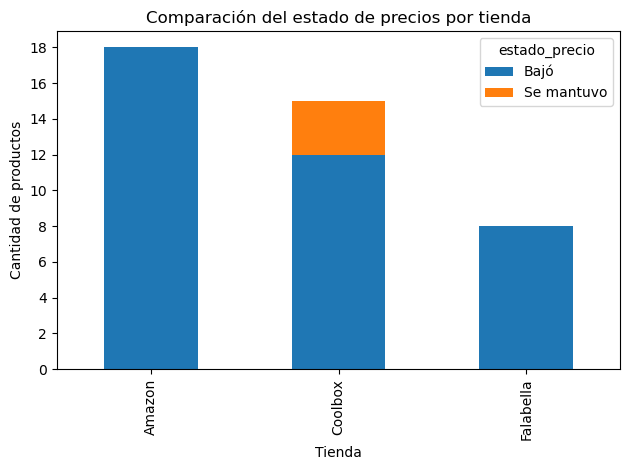

In [19]:
# Visualización: Estado de precios por tienda
from matplotlib.ticker import MaxNLocator

df_union.groupby("tienda")["estado_precio"].value_counts().unstack().plot(
    kind="bar",
    stacked=True,
    title="Comparación del estado de precios por tienda"
)

plt.xlabel("Tienda")
plt.ylabel("Cantidad de productos")

plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


### Índice de conveniencia

Se define un índice de conveniencia como la diferencia entre la cantidad
de productos cuyo precio bajó y aquellos cuyo precio subió.
Un valor más alto indica una tienda más favorable para el consumidor.


In [20]:
# Análisis de conveniencia por tienda
print("\n Análisis de conveniencia por tienda:")

resumen_tienda = (
    df_union
    .groupby(["tienda", "estado_precio"])
    .size()
    .unstack(fill_value=0)
)

print(resumen_tienda)

# Crear una métrica simple de conveniencia
resumen_tienda["indice_conveniencia"] = (
    resumen_tienda.get("Bajó", 0) - resumen_tienda.get("Subió", 0)
)

print("\n Índice de conveniencia por tienda:")
print(resumen_tienda["indice_conveniencia"].sort_values(ascending=False))


 Análisis de conveniencia por tienda:
estado_precio  Bajó  Se mantuvo
tienda                         
Amazon           18           0
Coolbox          12           3
Falabella         8           0

 Índice de conveniencia por tienda:
tienda
Amazon       18
Coolbox      12
Falabella     8
Name: indice_conveniencia, dtype: int64


### Visualización del índice de conveniencia por tienda

Se representa gráficamente el índice de conveniencia de cada tienda,
permitiendo comparar de forma visual cuál ofrece mejores condiciones
de compra según el comportamiento de sus precios.


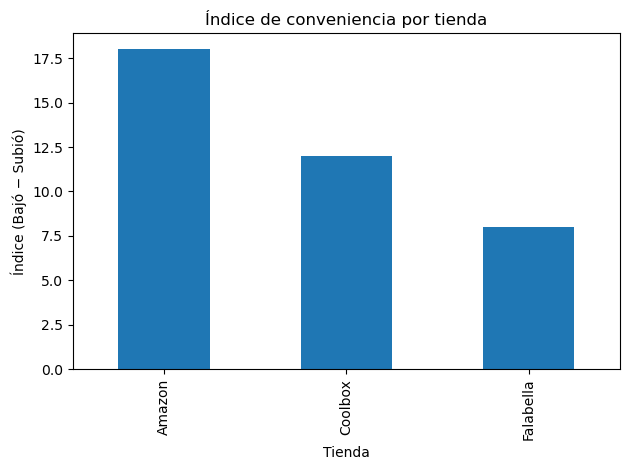

In [21]:
# # Visualización del índice de conveniencia por tienda 
resumen_tienda["indice_conveniencia"].plot(
    kind="bar",
    title="Índice de conveniencia por tienda"
)
plt.xlabel("Tienda")
plt.ylabel("Índice (Bajó − Subió)")
plt.tight_layout()
plt.show()